In [ ]:
import pandas as pd
import glob
import os

directory_hps = 'HPS'
os.chdir(directory_hps)
all_filenames_hps = glob.glob("*.csv")

combined_hps_df = pd.concat([pd.read_csv(f) for f in all_filenames_hps], ignore_index=True)

# Save the combined file
combined_hps_df.to_csv("combined_hps.csv", index=False)

In [3]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('combined_hps.csv')

print(df.shape)
print(df.columns)


/var/folders/gk/m6_7mj810mq3yvqdk1_1j5qr0000gn/T/ipykernel_71528/1214980120.py:10: DtypeWarning: Columns (0,230) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('combined_hps.csv')


(636254, 319)
Index(['SCRAM', 'CYCLE', 'EST_ST', 'EST_MSA', 'REGION', 'HWEIGHT', 'PWEIGHT',
       'TBIRTH_YEAR', 'ABIRTH_YEAR', 'RHISPANIC',
       ...
       'NDX11_HOUSING', 'NDX14_FOOD', 'NDX14_SHELTER', 'NDX14_MEDICAL',
       'NDX14_EMOTIONAL', 'NDX14_ELECTRICITY', 'NDX14_FRESHWATER',
       'NDX14_NONE_NEEDED', 'NDX16_INSURANCE', 'HHLD_NUMPER'],
      dtype='object', length=319)


In [6]:
# Remove duplicates based on respondent ID and survey date
df = df.drop_duplicates(subset=['SCRAMID', 'CYCLE'])

print("Data shape after dropping duplicates:", df.shape)

# Display missing value summary
print(df.isnull().sum())

num_vars = ['TWDAYS', 'INCOME', 'ANXIOUS', 'WORRY']
cat_vars = ['EST_ST', 'SEXUAL_ORIENTATION', 'RRACE']

# Imputation
num_imputer = SimpleImputer(strategy='median')
df[num_vars] = num_imputer.fit_transform(df[num_vars])

cat_imputer = SimpleImputer(strategy='most_frequent')
df[cat_vars] = cat_imputer.fit_transform(df[cat_vars])

# Encoding categorical variables
df = pd.get_dummies(df, columns=cat_vars, drop_first=True)

# Standardizing numeric variables
scaler = StandardScaler()
df[num_vars] = scaler.fit_transform(df[num_vars])

Data shape after dropping duplicates: (10173, 319)
SCRAM                10164
CYCLE                10164
EST_ST               10164
EST_MSA              10171
REGION               10164
                     ...  
NDX14_ELECTRICITY    10169
NDX14_FRESHWATER     10169
NDX14_NONE_NEEDED    10169
NDX16_INSURANCE      10171
HHLD_NUMPER          10074
Length: 319, dtype: int64


/var/folders/gk/m6_7mj810mq3yvqdk1_1j5qr0000gn/T/ipykernel_71528/1402402378.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[num_vars] = num_imputer.fit_transform(df[num_vars])
/var/folders/gk/m6_7mj810mq3yvqdk1_1j5qr0000gn/T/ipykernel_71528/1402402378.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[cat_vars] = cat_imputer.fit_transform(df[cat_vars])


In [7]:
# Example variables from dataset:
# Productivity proxy: WRKLOSSRV (work loss due to COVID-19, reverse coded as productivity)
# Remote work proxy: KINDWORK (type of work), ANYWORK (currently working)
# Mental health proxies: ANXIOUS, WORRY, INTEREST, DOWN
# Industry proxy: EST_ST (state) or REGION (region)

# Create a binary 'remote_work' variable based on KINDWORK or ANYWORK
df['remote_work'] = df['KINDWORK'].apply(lambda x: 1 if x == 1 else 0)  # assuming 1 = remote work

# Reverse code WRKLOSSRV to represent productivity (e.g., higher means less work loss, higher productivity)
df['productivity'] = 1 - df['WRKLOSSRV']  # adjust logic if needed

# Composite mental health score: mean of standardized 'ANXIOUS', 'WORRY', 'INTEREST', 'DOWN'
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[['ANXIOUS_s', 'WORRY_s', 'INTEREST_s', 'DOWN_s']] = scaler.fit_transform(df[['ANXIOUS', 'WORRY', 'INTEREST', 'DOWN']])
df['mental_health'] = df[['ANXIOUS_s', 'WORRY_s', 'INTEREST_s', 'DOWN_s']].mean(axis=1)

# Interaction between remote work and region for effect on productivity
df['remote_region_interaction'] = df['remote_work'] * df['REGION']

# Drop intermediate columns if desired
df.drop(columns=['ANXIOUS_s', 'WORRY_s', 'INTEREST_s', 'DOWN_s'], inplace=True)


               remote_work  productivity  mental_health    REGION
remote_work       1.000000     -0.016263      -0.002414 -0.100000
productivity     -0.016263      1.000000      -0.127285  0.353321
mental_health    -0.002414     -0.127285       1.000000  0.435293
REGION           -0.100000      0.353321       0.435293  1.000000


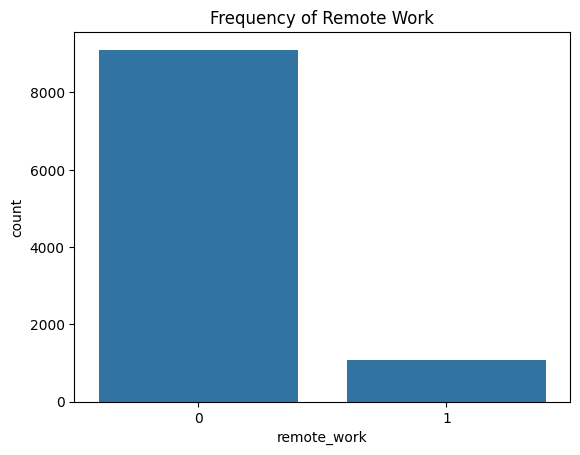

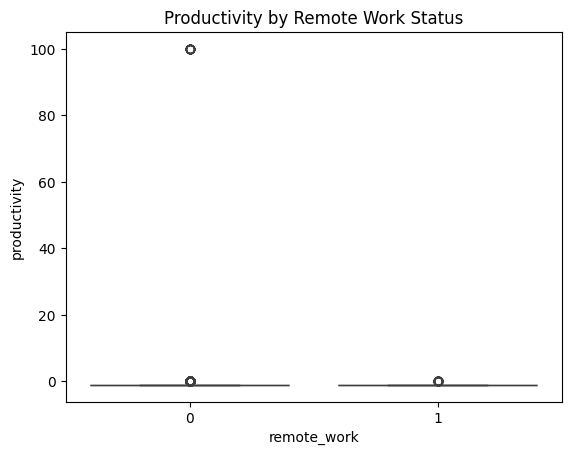

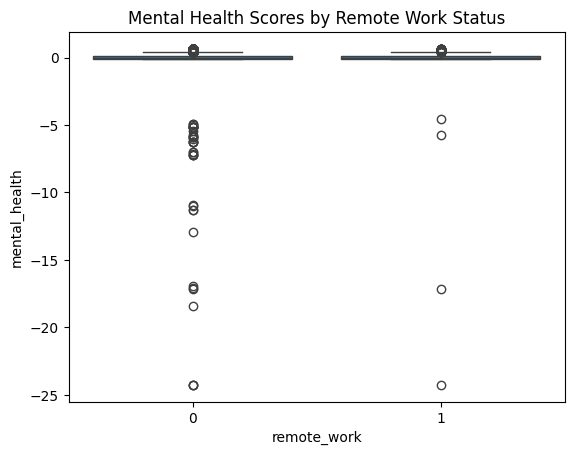

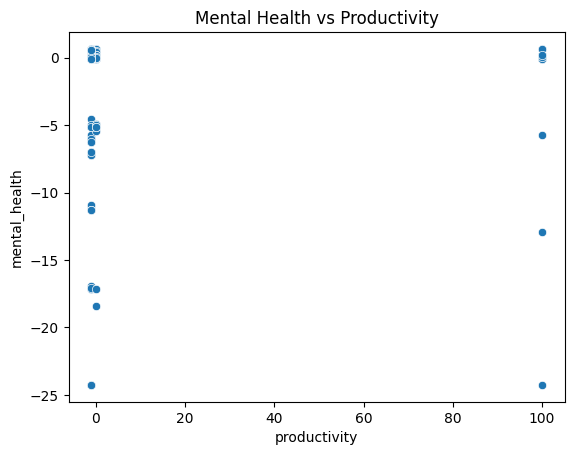

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Correlation matrix of key variables
corr_vars = ['remote_work', 'productivity', 'mental_health', 'REGION']
print(df[corr_vars].corr())

# Distribution of remote work
sns.countplot(x='remote_work', data=df)
plt.title('Frequency of Remote Work')
plt.show()

# Productivity vs Remote Work
sns.boxplot(x='remote_work', y='productivity', data=df)
plt.title('Productivity by Remote Work Status')
plt.show()

# Mental Health by remote work
sns.boxplot(x='remote_work', y='mental_health', data=df)
plt.title('Mental Health Scores by Remote Work Status')
plt.show()

# Scatter plot of productivity vs mental health
sns.scatterplot(x='productivity', y='mental_health', data=df)
plt.title('Mental Health vs Productivity')
plt.show()


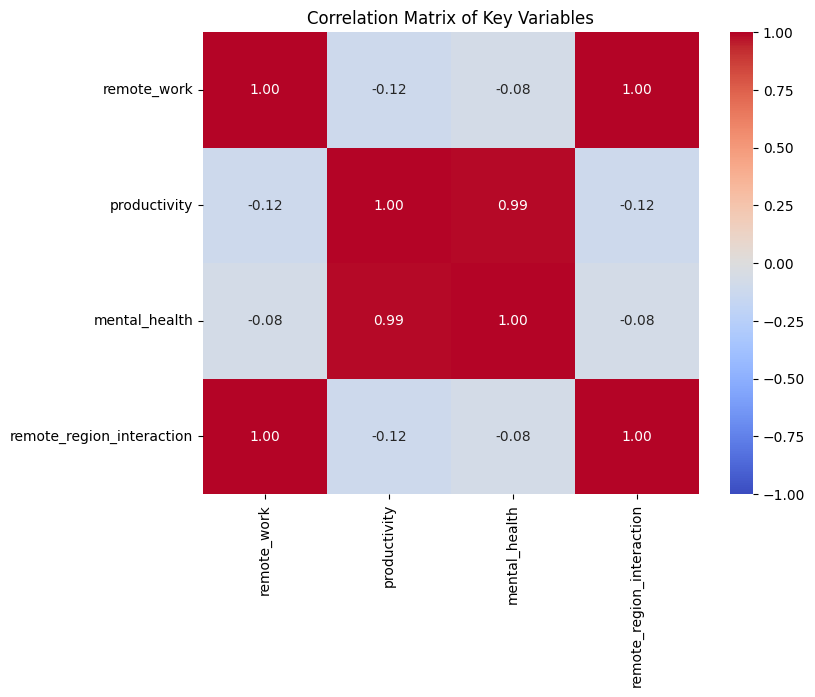

In [15]:
# Select numeric columns for correlation (including engineered features)
corr_vars = ['remote_work', 'productivity', 'mental_health', 'remote_region_interaction']

# Calculate correlation matrix (handle NaNs by dropping or filling temporarily)
corr_matrix = df[corr_vars].dropna().corr()

# Plot correlation matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Matrix of Key Variables')
plt.show()


In [11]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# For example, for the productivity model:
X_prod = df[['remote_work'] + [col for col in df.columns if col.startswith('REGION')] + ['remote_region_interaction']]
y_prod = df['productivity']

# Build a pipeline which imputes missing values then fits the model
pipeline_prod = make_pipeline(SimpleImputer(strategy='median'), LinearRegression())

# Split the data
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_prod, y_prod, test_size=0.3, random_state=42)

# Fit the model pipeline
pipeline_prod.fit(X_train_p, y_train_p)

# Score the model
print("Productivity model R^2:", pipeline_prod.score(X_test_p, y_test_p))


Productivity model R^2: 0.0011843162832001486


In [12]:
X_mh = df[['remote_work'] + [col for col in df.columns if col.startswith('REGION')]]
y_mh = df['mental_health']

pipeline_mh = make_pipeline(SimpleImputer(strategy='median'), LinearRegression())

X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_mh, y_mh, test_size=0.3, random_state=42)

pipeline_mh.fit(X_train_m, y_train_m)

print("Mental health model R^2:", pipeline_mh.score(X_test_m, y_test_m))


Mental health model R^2: -0.0020054169699874613
